In [1]:
!apt update && apt install -y python3-opencv
!pip install imageio

Unpacking libatspi2.0-0:amd64 (2.30.0-7) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../009-libxtst6_2%3a1.2.3-1_amd64.deb ...
7Progress: [  6%] [###.......................................................] 8Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package at-spi2-core.
Preparing to unpack .../010-at-spi2-core_2.30.0-7_amd64.deb ...
Unpacking at-spi2-core (2.30.0-7) ...
Selecting previously unselected package libsigsegv2:amd64.
Preparing to unpack .../011-libsigsegv2_2.12-2_amd64.deb ...
Unpacking libsigsegv2:amd64 (2.12-2) ...
Selecting previously unselected package m4.
Preparing to unpack .../012-m4_1.4.18-2_amd64.deb ...
Unpacking m4 (1.4.18-2) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../013-autoconf_2.69-11_all.deb ...
Unpacking autoconf (2.69-11) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../014-autotools-dev_20180224.1_all.deb ...
7Progress

# Chess board recognition

Recognition of a chess board and pieces using image processing techniques such as enhancement, filtering and segmentation. Final project for Digital Image Processing course at USP - São Carlos. Our aim is to process the images and reconstruct the FEN (Forsyth-Edwards Notation) of the current match represented on the board.

In [2]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

# Image Preprocessing and Cropping

In [3]:
# returns the angle between two vectors ab and ac
def get_angle(ab, ac):
    x = np.clip((ab @ ac) / np.linalg.norm(ab) / np.linalg.norm(ac), -1, 1)
    return np.degrees(np.arccos(x)) if not np.isnan(x) else 0

# check if the set of points form a square
def check_square(points):
    if len(points) != 4:
        return 4 * 90 ** 2, 0
    a, b, c, d = np.squeeze(points)
    bcd = get_angle(b - c, d - c)
    cda = get_angle(c - d, a - d)
    dab = get_angle(d - a, b - a)
    abc = get_angle(a - b, c - b)

    return np.sum((np.array([bcd, cda, dab, abc]) - 90) ** 2), np.mean(np.abs([a - b, b - c, c - d, d - a]))

# count how many squares are inside the square of index i
def child_count(i, hierarchy, is_square):
    j = hierarchy[0, i, 2]
    if j < 0:
        return 0

    total = 0
    while hierarchy[0, j, 0] > 0:
        j = hierarchy[0, j, 0]
    while j > 0:
        if is_square[j]:
            total += 1# + child_count(j, hierarchy, is_square)
        j = hierarchy[0, j, 1]
    return total

In [63]:
def get_contours(image, blur_radius):
    edge_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (blur_radius, blur_radius), 2)
    edge_image = cv2.Canny(edge_image, 20, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)),
        iterations=1
    )

    # find the contours
    contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # aproximates every contour group to a simpler polygon
    for i in range(len(contours)):
        contours[i] = cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)
    
    return contours, hierarchy

def get_candidate_boards(contours, hierarchy, max_error, min_side, min_child):
    square_info = list(map(lambda contour: check_square(contour), contours))
    is_square = list(map(lambda info: info[0] < max_error and info[1] > min_side, square_info))

    squares = []
    for i, square_flag, (error, side), contour in zip(range(len(contours)), is_square, square_info, contours):
        if square_flag:
            cnt = child_count(i, hierarchy, is_square)
            if cnt > min_child:
                squares.append(contour)

    return squares

def preprocess(image):
    image2 = np.copy(image)
    best_board = (None, 0)

    for blur in (3, 5, 7, 9, 11):
        contours, hierarchy = get_contours(image, blur)
        boards = get_candidate_boards(contours, hierarchy, 4 * 10 ** 2, 10, 10)
        for board in boards:
            error, side = check_square(board)
            if side > best_board[1]:
                best_board = (board, side)

    return best_board[0]

In [64]:
# rotate and crop the image, given the points of the new border
def crop_image(image, points):
    points = np.squeeze(points)
    low, high = points[np.lexsort((points[:, 1], points[:, 0]))[:2]]
    angle = -get_angle(np.array([0, 1]), high - low)
    #image[low[1]-10:low[1]+10, low[0]-10:low[0]+10] = (255, 0, 0)
    #image[high[1]-10:high[1]+10, high[0]-10:high[0]+10] = (0, 255, 255)
    if angle < -90:
        angle, low, high = angle + 180, high, low
    
    rot = cv2.getRotationMatrix2D((int(low[0]), int(low[1])), angle, 1.0)
    h, w = image.shape[:2]
    image = cv2.warpAffine(image, rot, (w, h))
    points = np.concatenate((points, np.ones(points.shape[0]).reshape((-1, 1))), axis=1)
    points = (rot @ points.T).T.astype(np.int32)
    
    image = image[points[:, 1].min():points[:, 1].max(), points[:, 0].min():points[:, 0].max()]
    return image

In [65]:
# read and resize the image
image = imageio.imread('/work/my-data/board2.jpg')
#w, h = image.shape[0], image.shape[1]
#if w < h:
#    w, h = 1500, int(1500 * w / h)
#else:
#    w, h = int(1500 * h / w), 1500
#image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)

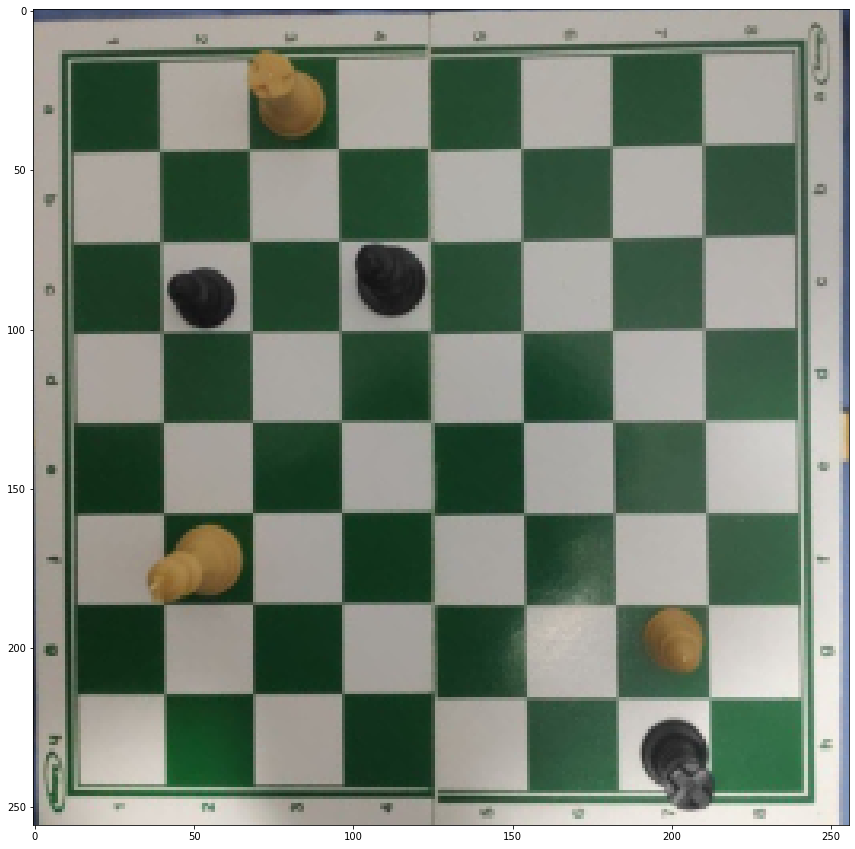

In [67]:
board = preprocess(image)
cropped = crop_image(image, board)
cropped = cv2.resize(cropped, (256, 256), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(15, 15))
plt.imshow(cropped)

# Convolutional Neural Network

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [73]:
image_in = keras.Input(shape=(256, 256, 3))

conv1 = layers.Conv2D(32, 3, padding='same')
leaky_relu1 = layers.LeakyReLU()
x = leaky_relu1(conv1(image_in))

conv2 = layers.Conv2D(32, 3, padding='same')
leaky_relu2 = layers.LeakyReLU()
x = leaky_relu2(conv2(x))

In [74]:
leaky_relu2.output_shape

(None, 256, 256, 32)

In [76]:
x = layers.Reshape((64, 32 * 32 * 32))(x)

In [77]:
dense1 = layers.Dense(256, activation='relu')
x = dense1(x)

dense2 = layers.Dense(13, activation='softmax')
out = dense2(x)

In [79]:
dense2.output_shape

(None, 64, 13)

In [80]:
model = keras.Model(inputs=image_in, outputs=out)

In [81]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 32, 32, 32)    0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 32768)         0     

In [88]:
y = model.predict(cropped.reshape((-1, 256, 256, 3)))

In [92]:
np.sum(y, axis=2).shape

(1, 64)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a990a5a8-7c3e-4bd5-890f-4e9b644eb2a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>